In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

In [2]:
insurance = pd.read_csv("after_Obamacare.csv")

In [3]:
insurance.shape

(833367, 8)

> Drop the year variable 

In [4]:
# Drop the 'YEAR' variable
insurance = insurance.drop(columns=["YEAR"])

In [5]:
insurance.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code
0,2,100.0,32.0,1.0,1.0,1,1
1,1,100.0,32.0,1.0,1.0,0,0
2,2,100.0,32.0,1.0,1.0,0,0
3,2,100.0,20.0,2.0,1.0,0,0
4,2,100.0,20.0,2.0,1.0,0,0


## Matching

In [6]:
# Convert all columns to integer type
insurance = insurance.astype(int)

In [7]:
# Display the data types of each column in the DataFrame
print("Data types of each variable in the DataFrame:")
print(insurance.dtypes)

Data types of each variable in the DataFrame:
SEX                int64
RACENEW            int64
INCFAM97ON2        int64
HINOTCOVE          int64
CNLUNG             int64
SMK                int64
Occupation_Code    int64
dtype: object


In [8]:
# Map 1 to 1 and 2 to 0 in the "HINOTCOVE" column
insurance["HINOTCOVE"] = insurance["HINOTCOVE"].map({1: 1, 2: 0})

# Check unique values in the "HINOTCOVE" column after mapping
unique_values = insurance["HINOTCOVE"].unique()
print(unique_values)

[1 0]


In [9]:
# Map 1 to 0 and 2 to 1 in the "CNLUNG" column
insurance["CNLUNG"] = insurance["CNLUNG"].map({1: 0, 2: 1})

# Check unique values in the "CNLUNG" column after mapping
unique_values = insurance["CNLUNG"].unique()
print(unique_values)

[0 1]


In [10]:
import dame_flame

model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result = model.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  1634
	Unmatched treated units:  5804 out of a total of  721837 treated units
	Unmatched control units:  79 out of a total of  111530 control units
	Number of matches made this iteration:  827484
	Number of matches made so far:  827484
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.0014109739486449185
Completed iteration 1 of matching
	Number of matched groups formed in total:  1660
	Unmatched treated units:  5763 out of a total of  721837 treated units
	Unmatched control units:  46 out of a total of  111530 control units
	Number of matches made this iteration:  74
	Number of matches made so far:  827558
	Covariates dropped so far:  frozenset({'SEX'})
	Predictive error of covariate set used to match:  0.0014109765229733178
Completed iteration 2 of matching
	Number of matched groups formed in total:  1691
	Unmatched treated units:  5439 out of a total of  721837 treated 

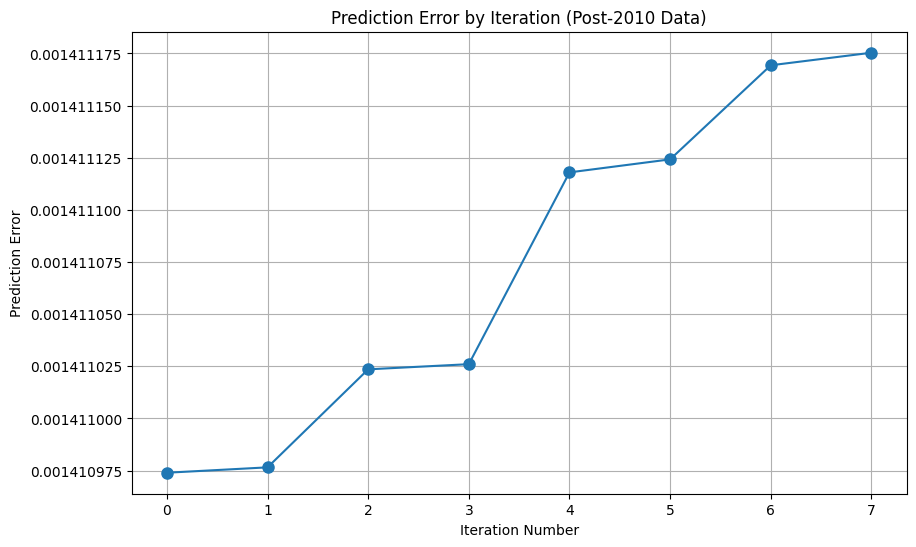

In [11]:
# Retrieve the prediction errors for each iteration
prediction_errors = model.pe_each_iter

# Plotting the prediction errors
plt.figure(figsize=(10, 6))
plt.plot(prediction_errors, marker="o", linestyle="-", markersize=8)
plt.title("Prediction Error by Iteration (Post-2010 Data)")
plt.xlabel("Iteration Number")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()

> I choose my stopping point at iteration number 1.

In [12]:
model_new = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=1,  # Stop after iteration 1
)
model_new.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result_new = model_new.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  1634
	Unmatched treated units:  5804 out of a total of  721837 treated units
	Unmatched control units:  79 out of a total of  111530 control units
	Number of matches made this iteration:  827484
	Number of matches made so far:  827484
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.0014109739486449185
Completed iteration 1 of matching
	Number of matched groups formed in total:  1660
	Unmatched treated units:  5763 out of a total of  721837 treated units
	Unmatched control units:  46 out of a total of  111530 control units
	Number of matches made this iteration:  74
	Number of matches made so far:  827558
	Covariates dropped so far:  frozenset({'SEX'})
	Predictive error of covariate set used to match:  0.0014109765229733178
827558 units matched. We stopped after iteration 1


In [13]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    # assert len(result_of_fit) == len(better)
    # assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [14]:
matched_data = get_dataframe(model_new, result_new)
matched_data.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code,match_group,match_group_size,weights
0,2,100,32,1,0,1,1,411.0,1070.0,1.000000
1,1,100,32,1,0,0,0,404.0,55916.0,1.000000
2,2,100,32,1,0,0,0,405.0,53084.0,1.000000
3,2,100,20,0,0,0,0,206.0,59285.0,0.939855
4,2,100,20,0,0,0,0,206.0,59285.0,0.939855


In [15]:
matched_data.shape

(827558, 10)

In [16]:
cnlung_counts = matched_data["CNLUNG"].value_counts()

print("Count of each unique value in CNLUNG:")
print(cnlung_counts)

Count of each unique value in CNLUNG:
CNLUNG
0    826705
1       853
Name: count, dtype: int64


In [17]:
print(f"Checking the Columns in matched data:")
matched_data.columns

Checking the Columns in matched data:


Index(['SEX', 'RACENEW', 'INCFAM97ON2', 'HINOTCOVE', 'CNLUNG', 'SMK',
       'Occupation_Code', 'match_group', 'match_group_size', 'weights'],
      dtype='object')

In [18]:
# Model with controls and robustness check
model_with_controls = smf.wls(
    "CNLUNG ~ C(HINOTCOVE) + C(SEX) + C(RACENEW) + C(INCFAM97ON2) + C(SMK) + C(Occupation_Code)",
    data=matched_data,
    weights=matched_data["weights"],
).fit(cov_type="HC3")

In [19]:
model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 CNLUNG   R-squared:                       0.006
Model:                            WLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     23.40
Date:                Wed, 01 May 2024   Prob (F-statistic):          1.61e-153
Time:                        00:55:01   Log-Likelihood:             1.6611e+06
No. Observations:              827558   AIC:                        -3.322e+06
Df Residuals:                  827521   BIC:                        -3.322e+06
Df Model:                          36                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0007      0.000     -5.975      0.000      -0.001      -0.000
C(HINOTCOVE)[T.1]            0.0010   6.21e-05     15.390      0.000       0.001       0.001
C(SEX)[T.2]                  0.0002   6.45e-05      3.544      0.000       0.000       0.000
C(RACENEW)[T.200]           -0.0002      0.000     -1.996      0.046      -0.000   -3.61e-06
C(RACENEW)[T.300]           -0.0006      0.000     -2.296      0.022      -0.001   -8.23e-05
C(RACENEW)[T.400]           -0.0002   8.83e-05     -2.343      0.019      -0.000   -3.38e-05
C(RACENEW)[T.530]           -0.0003   3.92e-05     -8.796      0.000      -0.000      -0.000
C(RACENEW)[T.541]           -0.0001      0.000     -0.637      0.524      -0.000       0.000
C(INCFAM97ON2)[T.10]         0.0003      0.000      2.257      0.024    3.92e-05       0.001
C(INCFAM97ON2)[T.20]        -0.0002      0.000     -2.081      0.037      -0.000   -1.44e-05
C(INCFAM97ON2)[T.31]        -0.0004      0.000     -3.180      0.001      -0.001      -0.000
C(INCFAM97ON2)[T.32]        -0.0006      0.000     -5.339      0.000      -0.001      -0.000
C(SMK)[T.1]                  0.0071      0.001     14.080      0.000       0.006       0.008
C(SMK)[T.2]                  0.0010      0.000      2.332      0.020       0.000       0.002
C(Occupation_Code)[T.1]    8.11e-07      0.001      0.002      0.999      -0.001       0.001
C(Occupation_Code)[T.2]      0.0006      0.001      0.950      0.342      -0.001       0.002
C(Occupation_Code)[T.3]     -0.0007      0.001     -1.227      0.220      -0.002       0.000
C(Occupation_Code)[T.4]      0.0024      0.001      3.245      0.001       0.001       0.004
C(Occupation_Code)[T.5]     -0.0004      0.001     -0.814      0.416      -0.002       0.001
C(Occupation_Code)[T.6]      0.0004      0.001      0.516      0.606      -0.001       0.002
C(Occupation_Code)[T.7]   4.663e-05      0.001      0.074      0.941      -0.001       0.001
C(Occupation_Code)[T.8]     -0.0003      0.001     -0.443      0.658      -0.002       0.001
C(Occupation_Code)[T.9]     -0.0002      0.001     -0.215      0.830      -0.002       0.001
C(Occupation_Code)[T.10]    -0.0010      0.001     -1.473      0.141      -0.002       0.000
C(Occupation_Code)[T.11]     0.0004      0.001      0.455      0.649      -0.001       0.002
C(Occupation_Code)[T.12]     0.0012      0.001      1.237      0.216      -0.001       0.003
C(Occupation_Code)[T.13]    -0.0014      0.001     -2.213      0.027      -0.003      -0.000
C(Occupation_Code)[T.14]    -0.0007      0.001     -0.937      0.349      -0.002       0.001
C(Occupation_Code)[T.15] -9.309e-05      0.001     -0.105      0.916      -0.002       0.002
C(Occupation_Code)[T.16]    -0.0005      0.001     -0.625      0.532      -0.002       0.001
C(Occupation_C

In [20]:
# To get the coefficient for the 'HINOTCOVE' variable
insurance_coefficient_control = model_with_controls.params["C(HINOTCOVE)[T.1]"]
print(f"Coefficient for 'HINOTCOVE' with controls: {insurance_coefficient_control:.4f}")

Coefficient for 'HINOTCOVE' with controls: 0.0010


In [21]:
# To get the p-value for the coefficient of 'HINOTCOVE' variable
insurance_p_value_control = model_with_controls.pvalues["C(HINOTCOVE)[T.1]"]
print(f"P-value for 'HINOTCOVE' with controls: {insurance_p_value_control:.4f}")

P-value for 'HINOTCOVE' with controls: 0.0000


>- The coefficient for 'HINOTCOVE' with controls (0.0010) suggests that, after controlling for other variables, there is a positive association between having insurance coverage and the outcome variable (lung cancer diagnosis status). 
>- The p-value is less than the conventional threshold of 0.05, suggesting that the estimated effect of insurance coverage on lung cancer diagnosis is statistically significant.
>- There is evidence to support the hypothesis that having insurance coverage increases the likelihood of lung cancer diagnosis, after controlling for other covariates and potential confounders.